In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'random_occlusion', 'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}
Validation folders considered: {'random_occlusion', 'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}
Test folders considered: {'random_occlusion', 'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}
Validation folders considered: {'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}
Test folders considered: {'low_resolution', 'dirty_lens', 'original', 'blur', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'gaussian_noise'}


In [7]:
# -----------------------------
# 2. Define Vision Transformer (ViT) Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import math

class PatchEmbedding(nn.Module):
    """Patch Embedding Layer - Convert image to patches and embed them"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Use Conv2d to create patch embeddings
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H', W') where H' = H/patch_size, W' = W/patch_size
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim=768, n_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        assert self.head_dim * n_heads == embed_dim, "embed_dim must be divisible by n_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, N, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    """Multi-Layer Perceptron (Feed-Forward Network)"""
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer Encoder Block"""
    def __init__(self, embed_dim=768, n_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, dropout=dropout)
        
    def forward(self, x):
        # Pre-norm architecture (Layer Norm before attention and MLP)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MyVisionTransformer(nn.Module):
    """Vision Transformer (ViT) Implementation from Scratch"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, 
                 embed_dim=768, depth=12, n_heads=12, mlp_ratio=4.0, dropout=0.1, 
                 emb_dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.num_tokens = 1  # CLS token
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(emb_dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights"""
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize other weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, n_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final layer norm and classification
        x = self.norm(x)
        
        # Use CLS token for classification
        cls_token_final = x[:, 0]  # (B, embed_dim)
        x = self.head(cls_token_final)  # (B, num_classes)
        
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViT-Base configuration
model = MyVisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=len(classes),
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.0,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)  # Lower LR for ViT

print("Vision Transformer (ViT) Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

Vision Transformer (ViT) Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
    PatchEmbedding-2             [-1, 196, 768]               0
           Dropout-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6         [-1, 12, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8             [-1, 197, 768]               0
MultiHeadAttention-9             [-1, 197, 768]               0
        LayerNorm-10             [-1, 197, 768]           1,536
           Linear-11            [-1, 197, 3072]       2,362,368
             GELU-12            [-1, 197, 3072]               0
          Dropout-13            [-1, 197, 3072]               0


🚀 Starting Vision Transformer Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:09<00:00,  1.45s/it, Loss=0.7491, Acc=0.5974]


✅ Training completed in 69.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:08<00:00,  1.44it/s, Loss=0.9602, Acc=0.6172]


✅ Validation completed in 8.37s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.6172

📊 Epoch 1 Summary:
│ Train Loss: 0.7491 | Train Acc: 0.5974
│ Val Loss:   0.9602 | Val Acc:   0.6172
│ Train Time: 69.57s | Val Time: 8.37s
│ Total Epoch Time: 77.94s
│ Best Val Acc: 0.6172 (Epoch 1)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.33s/it, Loss=0.8221, Acc=0.5533]


✅ Training completed in 64.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.9245, Acc=0.4323]


✅ Validation completed in 6.45s

📊 Epoch 2 Summary:
│ Train Loss: 0.8221 | Train Acc: 0.5533
│ Val Loss:   0.9245 | Val Acc:   0.4323
│ Train Time: 64.03s | Val Time: 6.45s
│ Total Epoch Time: 70.49s
│ Best Val Acc: 0.6172 (Epoch 1)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.35s/it, Loss=0.6955, Acc=0.5974]


✅ Training completed in 64.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7249, Acc=0.6068]


✅ Validation completed in 6.49s

📊 Epoch 3 Summary:
│ Train Loss: 0.6955 | Train Acc: 0.5974
│ Val Loss:   0.7249 | Val Acc:   0.6068
│ Train Time: 64.77s | Val Time: 6.49s
│ Total Epoch Time: 71.26s
│ Best Val Acc: 0.6172 (Epoch 1)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.7282, Acc=0.5737]


✅ Training completed in 64.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.82it/s, Loss=0.8937, Acc=0.6250]


✅ Validation completed in 6.58s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.6250

📊 Epoch 4 Summary:
│ Train Loss: 0.7282 | Train Acc: 0.5737
│ Val Loss:   0.8937 | Val Acc:   0.6250
│ Train Time: 64.44s | Val Time: 6.58s
│ Total Epoch Time: 71.03s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.7272, Acc=0.5697]


✅ Training completed in 64.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7821, Acc=0.6172]


✅ Validation completed in 6.52s

📊 Epoch 5 Summary:
│ Train Loss: 0.7272 | Train Acc: 0.5697
│ Val Loss:   0.7821 | Val Acc:   0.6172
│ Train Time: 64.14s | Val Time: 6.52s
│ Total Epoch Time: 70.67s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6798, Acc=0.5888]


✅ Training completed in 64.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=1.0326, Acc=0.4062]


✅ Validation completed in 6.47s

📊 Epoch 6 Summary:
│ Train Loss: 0.6798 | Train Acc: 0.5888
│ Val Loss:   1.0326 | Val Acc:   0.4062
│ Train Time: 64.29s | Val Time: 6.47s
│ Total Epoch Time: 70.77s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.7048, Acc=0.5658]


✅ Training completed in 64.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.82it/s, Loss=0.6730, Acc=0.6224]


✅ Validation completed in 6.60s

📊 Epoch 7 Summary:
│ Train Loss: 0.7048 | Train Acc: 0.5658
│ Val Loss:   0.6730 | Val Acc:   0.6224
│ Train Time: 64.19s | Val Time: 6.60s
│ Total Epoch Time: 70.79s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6974, Acc=0.5763]


✅ Training completed in 64.35s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.8668, Acc=0.6250]


✅ Validation completed in 6.49s

📊 Epoch 8 Summary:
│ Train Loss: 0.6974 | Train Acc: 0.5763
│ Val Loss:   0.8668 | Val Acc:   0.6250
│ Train Time: 64.35s | Val Time: 6.49s
│ Total Epoch Time: 70.83s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=0.7023, Acc=0.5967]


✅ Training completed in 63.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.83it/s, Loss=0.8242, Acc=0.6250]


✅ Validation completed in 6.55s

📊 Epoch 9 Summary:
│ Train Loss: 0.7023 | Train Acc: 0.5967
│ Val Loss:   0.8242 | Val Acc:   0.6250
│ Train Time: 63.91s | Val Time: 6.55s
│ Total Epoch Time: 70.46s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6886, Acc=0.5829]


✅ Training completed in 64.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7238, Acc=0.4922]


✅ Validation completed in 6.52s

📊 Epoch 10 Summary:
│ Train Loss: 0.6886 | Train Acc: 0.5829
│ Val Loss:   0.7238 | Val Acc:   0.4922
│ Train Time: 64.28s | Val Time: 6.52s
│ Total Epoch Time: 70.80s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6767, Acc=0.5789]


✅ Training completed in 64.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.6854, Acc=0.6198]


✅ Validation completed in 6.49s

📊 Epoch 11 Summary:
│ Train Loss: 0.6767 | Train Acc: 0.5789
│ Val Loss:   0.6854 | Val Acc:   0.6198
│ Train Time: 64.17s | Val Time: 6.49s
│ Total Epoch Time: 70.67s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6652, Acc=0.5803]


✅ Training completed in 64.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7369, Acc=0.5781]


✅ Validation completed in 6.47s

📊 Epoch 12 Summary:
│ Train Loss: 0.6652 | Train Acc: 0.5803
│ Val Loss:   0.7369 | Val Acc:   0.5781
│ Train Time: 64.13s | Val Time: 6.47s
│ Total Epoch Time: 70.60s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.33s/it, Loss=0.6586, Acc=0.5987]


✅ Training completed in 64.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.6916, Acc=0.6250]


✅ Validation completed in 6.52s

📊 Epoch 13 Summary:
│ Train Loss: 0.6586 | Train Acc: 0.5987
│ Val Loss:   0.6916 | Val Acc:   0.6250
│ Train Time: 64.02s | Val Time: 6.52s
│ Total Epoch Time: 70.54s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=0.6474, Acc=0.6020]


✅ Training completed in 63.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7009, Acc=0.6250]


✅ Validation completed in 6.44s

📊 Epoch 14 Summary:
│ Train Loss: 0.6474 | Train Acc: 0.6020
│ Val Loss:   0.7009 | Val Acc:   0.6250
│ Train Time: 63.98s | Val Time: 6.44s
│ Total Epoch Time: 70.43s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6642, Acc=0.5961]


✅ Training completed in 64.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.87it/s, Loss=0.8212, Acc=0.4323]


✅ Validation completed in 6.42s

📊 Epoch 15 Summary:
│ Train Loss: 0.6642 | Train Acc: 0.5961
│ Val Loss:   0.8212 | Val Acc:   0.4323
│ Train Time: 64.14s | Val Time: 6.42s
│ Total Epoch Time: 70.56s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6472, Acc=0.6178]


✅ Training completed in 64.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7666, Acc=0.5911]


✅ Validation completed in 6.53s

📊 Epoch 16 Summary:
│ Train Loss: 0.6472 | Train Acc: 0.6178
│ Val Loss:   0.7666 | Val Acc:   0.5911
│ Train Time: 64.27s | Val Time: 6.53s
│ Total Epoch Time: 70.80s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6478, Acc=0.6053]


✅ Training completed in 64.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.83it/s, Loss=0.7572, Acc=0.6250]


✅ Validation completed in 6.56s

📊 Epoch 17 Summary:
│ Train Loss: 0.6478 | Train Acc: 0.6053
│ Val Loss:   0.7572 | Val Acc:   0.6250
│ Train Time: 64.33s | Val Time: 6.56s
│ Total Epoch Time: 70.89s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6365, Acc=0.6125]


✅ Training completed in 64.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7421, Acc=0.6250]


✅ Validation completed in 6.48s

📊 Epoch 18 Summary:
│ Train Loss: 0.6365 | Train Acc: 0.6125
│ Val Loss:   0.7421 | Val Acc:   0.6250
│ Train Time: 64.41s | Val Time: 6.48s
│ Total Epoch Time: 70.89s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6419, Acc=0.6007]


✅ Training completed in 64.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.6581, Acc=0.6224]


✅ Validation completed in 6.45s

📊 Epoch 19 Summary:
│ Train Loss: 0.6419 | Train Acc: 0.6007
│ Val Loss:   0.6581 | Val Acc:   0.6224
│ Train Time: 64.46s | Val Time: 6.45s
│ Total Epoch Time: 70.91s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6419, Acc=0.6151]


✅ Training completed in 64.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7421, Acc=0.6250]


✅ Validation completed in 6.46s

📊 Epoch 20 Summary:
│ Train Loss: 0.6419 | Train Acc: 0.6151
│ Val Loss:   0.7421 | Val Acc:   0.6250
│ Train Time: 64.38s | Val Time: 6.46s
│ Total Epoch Time: 70.85s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6458, Acc=0.6145]


✅ Training completed in 64.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7005, Acc=0.6250]


✅ Validation completed in 6.51s

📊 Epoch 21 Summary:
│ Train Loss: 0.6458 | Train Acc: 0.6145
│ Val Loss:   0.7005 | Val Acc:   0.6250
│ Train Time: 64.42s | Val Time: 6.51s
│ Total Epoch Time: 70.93s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6352, Acc=0.6000]


✅ Training completed in 64.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.6960, Acc=0.6250]


✅ Validation completed in 6.54s

📊 Epoch 22 Summary:
│ Train Loss: 0.6352 | Train Acc: 0.6000
│ Val Loss:   0.6960 | Val Acc:   0.6250
│ Train Time: 64.27s | Val Time: 6.54s
│ Total Epoch Time: 70.81s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6240, Acc=0.6184]


✅ Training completed in 64.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7328, Acc=0.6250]


✅ Validation completed in 6.45s

📊 Epoch 23 Summary:
│ Train Loss: 0.6240 | Train Acc: 0.6184
│ Val Loss:   0.7328 | Val Acc:   0.6250
│ Train Time: 64.25s | Val Time: 6.45s
│ Total Epoch Time: 70.70s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6344, Acc=0.6164]


✅ Training completed in 64.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7245, Acc=0.6250]


✅ Validation completed in 6.44s

📊 Epoch 24 Summary:
│ Train Loss: 0.6344 | Train Acc: 0.6164
│ Val Loss:   0.7245 | Val Acc:   0.6250
│ Train Time: 64.39s | Val Time: 6.44s
│ Total Epoch Time: 70.84s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6324, Acc=0.6224]


✅ Training completed in 64.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.88it/s, Loss=0.7688, Acc=0.6250]


✅ Validation completed in 6.38s

📊 Epoch 25 Summary:
│ Train Loss: 0.6324 | Train Acc: 0.6224
│ Val Loss:   0.7688 | Val Acc:   0.6250
│ Train Time: 64.22s | Val Time: 6.38s
│ Total Epoch Time: 70.60s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.33s/it, Loss=0.6347, Acc=0.6204]


✅ Training completed in 64.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7501, Acc=0.6250]


✅ Validation completed in 6.47s

📊 Epoch 26 Summary:
│ Train Loss: 0.6347 | Train Acc: 0.6204
│ Val Loss:   0.7501 | Val Acc:   0.6250
│ Train Time: 64.08s | Val Time: 6.47s
│ Total Epoch Time: 70.56s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=0.6302, Acc=0.6217]


✅ Training completed in 63.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7711, Acc=0.6224]


✅ Validation completed in 6.47s

📊 Epoch 27 Summary:
│ Train Loss: 0.6302 | Train Acc: 0.6217
│ Val Loss:   0.7711 | Val Acc:   0.6224
│ Train Time: 63.96s | Val Time: 6.47s
│ Total Epoch Time: 70.43s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6299, Acc=0.6184]


✅ Training completed in 64.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7770, Acc=0.6250]


✅ Validation completed in 6.50s

📊 Epoch 28 Summary:
│ Train Loss: 0.6299 | Train Acc: 0.6184
│ Val Loss:   0.7770 | Val Acc:   0.6250
│ Train Time: 64.15s | Val Time: 6.50s
│ Total Epoch Time: 70.66s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6268, Acc=0.6145]


✅ Training completed in 64.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7389, Acc=0.6250]


✅ Validation completed in 6.54s

📊 Epoch 29 Summary:
│ Train Loss: 0.6268 | Train Acc: 0.6145
│ Val Loss:   0.7389 | Val Acc:   0.6250
│ Train Time: 64.44s | Val Time: 6.54s
│ Total Epoch Time: 70.98s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6259, Acc=0.6224]


✅ Training completed in 64.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.83it/s, Loss=0.7700, Acc=0.6250]


✅ Validation completed in 6.56s

📊 Epoch 30 Summary:
│ Train Loss: 0.6259 | Train Acc: 0.6224
│ Val Loss:   0.7700 | Val Acc:   0.6250
│ Train Time: 64.49s | Val Time: 6.56s
│ Total Epoch Time: 71.06s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6263, Acc=0.6204]


✅ Training completed in 64.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7938, Acc=0.4609]


✅ Validation completed in 6.52s

📊 Epoch 31 Summary:
│ Train Loss: 0.6263 | Train Acc: 0.6204
│ Val Loss:   0.7938 | Val Acc:   0.4609
│ Train Time: 64.40s | Val Time: 6.52s
│ Total Epoch Time: 70.93s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.35s/it, Loss=0.6254, Acc=0.6105]


✅ Training completed in 64.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7679, Acc=0.6250]


✅ Validation completed in 6.49s

📊 Epoch 32 Summary:
│ Train Loss: 0.6254 | Train Acc: 0.6105
│ Val Loss:   0.7679 | Val Acc:   0.6250
│ Train Time: 64.77s | Val Time: 6.49s
│ Total Epoch Time: 71.26s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6232, Acc=0.6033]


✅ Training completed in 64.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.87it/s, Loss=0.7482, Acc=0.6250]


✅ Validation completed in 6.43s

📊 Epoch 33 Summary:
│ Train Loss: 0.6232 | Train Acc: 0.6033
│ Val Loss:   0.7482 | Val Acc:   0.6250
│ Train Time: 64.29s | Val Time: 6.43s
│ Total Epoch Time: 70.72s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6229, Acc=0.6243]


✅ Training completed in 64.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7461, Acc=0.6250]


✅ Validation completed in 6.52s

📊 Epoch 34 Summary:
│ Train Loss: 0.6229 | Train Acc: 0.6243
│ Val Loss:   0.7461 | Val Acc:   0.6250
│ Train Time: 64.34s | Val Time: 6.52s
│ Total Epoch Time: 70.86s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6299, Acc=0.6105]


✅ Training completed in 64.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7393, Acc=0.4531]


✅ Validation completed in 6.54s

📊 Epoch 35 Summary:
│ Train Loss: 0.6299 | Train Acc: 0.6105
│ Val Loss:   0.7393 | Val Acc:   0.4531
│ Train Time: 64.22s | Val Time: 6.54s
│ Total Epoch Time: 70.76s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6207, Acc=0.6243]


✅ Training completed in 64.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.88it/s, Loss=0.7363, Acc=0.6250]


✅ Validation completed in 6.39s

📊 Epoch 36 Summary:
│ Train Loss: 0.6207 | Train Acc: 0.6243
│ Val Loss:   0.7363 | Val Acc:   0.6250
│ Train Time: 64.52s | Val Time: 6.39s
│ Total Epoch Time: 70.92s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=0.6290, Acc=0.6191]


✅ Training completed in 63.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7734, Acc=0.6250]


✅ Validation completed in 6.45s

📊 Epoch 37 Summary:
│ Train Loss: 0.6290 | Train Acc: 0.6191
│ Val Loss:   0.7734 | Val Acc:   0.6250
│ Train Time: 63.87s | Val Time: 6.45s
│ Total Epoch Time: 70.32s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6207, Acc=0.6283]


✅ Training completed in 64.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7566, Acc=0.6250]


✅ Validation completed in 6.45s

📊 Epoch 38 Summary:
│ Train Loss: 0.6207 | Train Acc: 0.6283
│ Val Loss:   0.7566 | Val Acc:   0.6250
│ Train Time: 64.14s | Val Time: 6.45s
│ Total Epoch Time: 70.60s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6220, Acc=0.6237]


✅ Training completed in 64.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7258, Acc=0.6250]


✅ Validation completed in 6.48s

📊 Epoch 39 Summary:
│ Train Loss: 0.6220 | Train Acc: 0.6237
│ Val Loss:   0.7258 | Val Acc:   0.6250
│ Train Time: 64.44s | Val Time: 6.48s
│ Total Epoch Time: 70.93s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6167, Acc=0.6270]


✅ Training completed in 64.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7461, Acc=0.6250]


✅ Validation completed in 6.52s

📊 Epoch 40 Summary:
│ Train Loss: 0.6167 | Train Acc: 0.6270
│ Val Loss:   0.7461 | Val Acc:   0.6250
│ Train Time: 64.42s | Val Time: 6.52s
│ Total Epoch Time: 70.94s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6131, Acc=0.6362]


✅ Training completed in 64.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.83it/s, Loss=0.7089, Acc=0.6224]


✅ Validation completed in 6.57s

📊 Epoch 41 Summary:
│ Train Loss: 0.6131 | Train Acc: 0.6362
│ Val Loss:   0.7089 | Val Acc:   0.6224
│ Train Time: 64.51s | Val Time: 6.57s
│ Total Epoch Time: 71.08s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6127, Acc=0.6349]


✅ Training completed in 64.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7574, Acc=0.6250]


✅ Validation completed in 6.45s

📊 Epoch 42 Summary:
│ Train Loss: 0.6127 | Train Acc: 0.6349
│ Val Loss:   0.7574 | Val Acc:   0.6250
│ Train Time: 64.16s | Val Time: 6.45s
│ Total Epoch Time: 70.61s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6159, Acc=0.6184]


✅ Training completed in 64.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7035, Acc=0.6198]


✅ Validation completed in 6.51s

📊 Epoch 43 Summary:
│ Train Loss: 0.6159 | Train Acc: 0.6184
│ Val Loss:   0.7035 | Val Acc:   0.6198
│ Train Time: 64.22s | Val Time: 6.51s
│ Total Epoch Time: 70.73s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6131, Acc=0.6355]


✅ Training completed in 64.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7832, Acc=0.5990]


✅ Validation completed in 6.51s

📊 Epoch 44 Summary:
│ Train Loss: 0.6131 | Train Acc: 0.6355
│ Val Loss:   0.7832 | Val Acc:   0.5990
│ Train Time: 64.34s | Val Time: 6.51s
│ Total Epoch Time: 70.85s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6158, Acc=0.6270]


✅ Training completed in 64.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.83it/s, Loss=0.7610, Acc=0.5964]


✅ Validation completed in 6.55s

📊 Epoch 45 Summary:
│ Train Loss: 0.6158 | Train Acc: 0.6270
│ Val Loss:   0.7610 | Val Acc:   0.5964
│ Train Time: 64.40s | Val Time: 6.55s
│ Total Epoch Time: 70.95s
│ Best Val Acc: 0.6250 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6228, Acc=0.6211]


✅ Training completed in 64.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.87it/s, Loss=0.7208, Acc=0.6354]


✅ Validation completed in 6.42s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.6354

📊 Epoch 46 Summary:
│ Train Loss: 0.6228 | Train Acc: 0.6211
│ Val Loss:   0.7208 | Val Acc:   0.6354
│ Train Time: 64.31s | Val Time: 6.42s
│ Total Epoch Time: 70.74s
│ Best Val Acc: 0.6354 (Epoch 46)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6110, Acc=0.6296]


✅ Training completed in 64.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.86it/s, Loss=0.7438, Acc=0.6042]


✅ Validation completed in 6.46s

📊 Epoch 47 Summary:
│ Train Loss: 0.6110 | Train Acc: 0.6296
│ Val Loss:   0.7438 | Val Acc:   0.6042
│ Train Time: 64.11s | Val Time: 6.46s
│ Total Epoch Time: 70.57s
│ Best Val Acc: 0.6354 (Epoch 46)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.6073, Acc=0.6500]


✅ Training completed in 64.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7472, Acc=0.5990]


✅ Validation completed in 6.48s

📊 Epoch 48 Summary:
│ Train Loss: 0.6073 | Train Acc: 0.6500
│ Val Loss:   0.7472 | Val Acc:   0.5990
│ Train Time: 64.43s | Val Time: 6.48s
│ Total Epoch Time: 70.91s
│ Best Val Acc: 0.6354 (Epoch 46)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.5980, Acc=0.6513]


✅ Training completed in 64.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.85it/s, Loss=0.7303, Acc=0.5938]


✅ Validation completed in 6.51s

📊 Epoch 49 Summary:
│ Train Loss: 0.5980 | Train Acc: 0.6513
│ Val Loss:   0.7303 | Val Acc:   0.5938
│ Train Time: 64.54s | Val Time: 6.51s
│ Total Epoch Time: 71.05s
│ Best Val Acc: 0.6354 (Epoch 46)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:04<00:00,  1.34s/it, Loss=0.5968, Acc=0.6671]


✅ Training completed in 64.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:06<00:00,  1.84it/s, Loss=0.7192, Acc=0.5703]


✅ Validation completed in 6.53s

📊 Epoch 50 Summary:
│ Train Loss: 0.5968 | Train Acc: 0.6671
│ Val Loss:   0.7192 | Val Acc:   0.5703
│ Train Time: 64.38s | Val Time: 6.53s
│ Total Epoch Time: 70.91s
│ Best Val Acc: 0.6354 (Epoch 46)
│ GPU Memory: 1.3GB / 6.7GB

💾 Best Vision Transformer model saved as 'best_vit_model.pth'
📊 Best model stats:
│ Best Epoch: 46
│ Best Val Acc: 0.6354

💾 Vision Transformer training history saved to 'vit_training_history.csv'

🎉 Vision Transformer Training Complete!
Total Training Time: 3546.41s (59.1 minutes)
Average Epoch Time: 70.93s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 77.94s
│ Epoch 2: 70.49s
│ Epoch 3: 71.26s
│ Epoch 4: 71.03s
│ Epoch 5: 70.67s
│ Epoch 6: 70.77s
│ Epoch 7: 70.79s
│ Epoch 8: 70.83s
│ Epoch 9: 70.46s
│ Epoch 10: 70.80s
│ Epoch 11: 70.67s
│ Epoch 12: 70.60s
│ Epoch 13: 70.54s
│ Epoch 14: 70.43s
│ Epoch 15: 70.56s
│ Epoch 16: 70.80s
│ Epoch 17: 70.89s
│ Epoch 18: 70.89s
│ Epoch 19: 70.91s
│ Epoch 20: 70.85s
│ Epoch 21: 70.93s
│ Epoch

Testing Vision Transformer: 100%|██████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


✅ Vision Transformer Testing completed in 11.34s

📋 Vision Transformer Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.63      0.84      0.72       304
   spin_bowl       0.42      0.20      0.27       184

    accuracy                           0.60       488
   macro avg       0.53      0.52      0.49       488
weighted avg       0.55      0.60      0.55       488

🎯 Vision Transformer Test Accuracy: 0.5963

📊 Vision Transformer Model Performance Summary:
│ Best Validation Acc:  0.6354 (Epoch 46)
│ Final Test Accuracy:  0.5963
│ Val-Test Gap:         0.0391


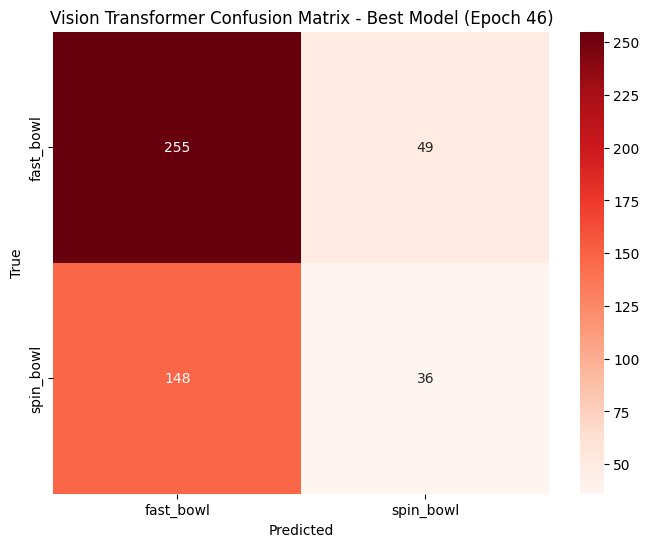

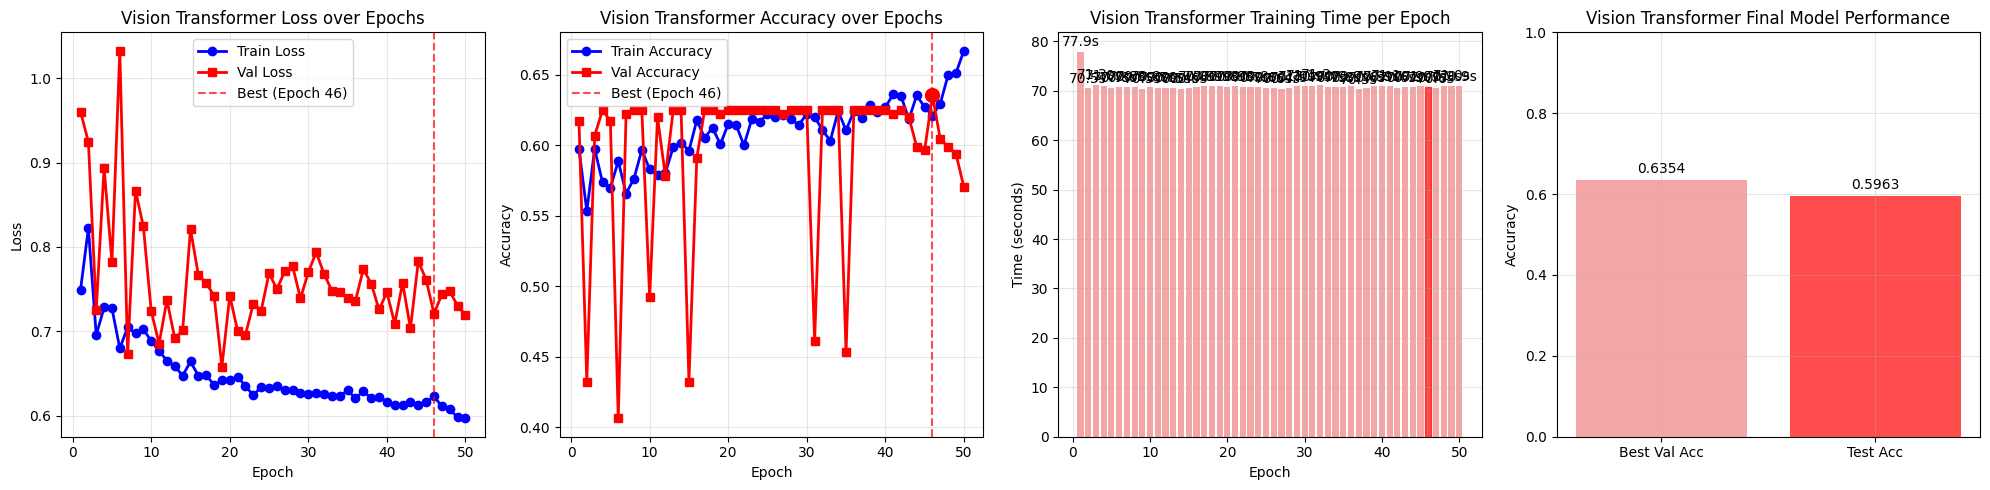


⏰ Vision Transformer Final Timing Summary:
│ Total Training: 3546.41s
│ Average per Epoch: 70.93s
│ Testing Time: 11.34s
│ Total Runtime: 3557.75s

💾 Vision Transformer Files saved:
│ best_vit_model.pth - Best validation accuracy model
│ vit_training_history.csv - Training metrics for later plotting

🏗️  Vision Transformer Architecture Summary:
│ Total Parameters: 85,800,194
│ Trainable Parameters: 85,800,194
│ Model Size: 327.30 MB
│ Input Size: 224x224x3
│ Patch Size: 16x16
│ Number of Patches: 196
│ Embed Dimension: 768
│ Number of Heads: 12
│ Number of Layers: 12
│ MLP Ratio: 4.0
│ Output Classes: 2
│ Activation: GELU
│ Attention Dropout: 0.1
│ Embedding Dropout: 0.1


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - Vision Transformer
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting Vision Transformer Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best Vision Transformer model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_vit_model.pth')
    print(f"\n💾 Best Vision Transformer model saved as 'best_vit_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('vit_training_history.csv', index=False)
print("\n💾 Vision Transformer training history saved to 'vit_training_history.csv'")

# Training Summary
print(f"\n🎉 Vision Transformer Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Vision Transformer Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best Vision Transformer model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing Vision Transformer", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Vision Transformer Testing completed in {test_time:.2f}s")
print("\n📋 Vision Transformer Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Vision Transformer Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 Vision Transformer Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Vision Transformer Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("Vision Transformer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='red', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightcoral', alpha=0.7)
bars[best_epoch-1].set_color('red')
plt.title("Vision Transformer Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightcoral', 'red']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Vision Transformer Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ Vision Transformer Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 Vision Transformer Files saved:")
print(f"│ best_vit_model.pth - Best validation accuracy model")
print(f"│ vit_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. Vision Transformer Architecture Summary
# -----------------------------
print(f"\n🏗️  Vision Transformer Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Patch Size: 16x16")
print(f"│ Number of Patches: {model.patch_embed.n_patches}")
print(f"│ Embed Dimension: {model.embed_dim}")
print(f"│ Number of Heads: 12")
print(f"│ Number of Layers: 12")
print(f"│ MLP Ratio: 4.0")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Activation: GELU")
print(f"│ Attention Dropout: 0.1")
print(f"│ Embedding Dropout: 0.1")
